# Demo Notebook how to run models on static mouse datasets

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2 

In [2]:
import os
import datajoint as dj
dj.config['database.host'] = os.environ['DJ_HOST']
dj.config['database.user'] = os.environ['DJ_USER']
dj.config['database.password'] = os.environ['DJ_PASS']
dj.config['enable_python_native_blobs'] = True
dj.config['display.limit'] = 200

name = 'iclr' #"test"
dj.config['schema_name'] = f"konstantin_nnsysident_{name}"

In [34]:
import torch
import numpy as np
import pickle 
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)
from collections import OrderedDict, Iterable
import matplotlib.pyplot as plt
import matplotlib
import re
import seaborn as sns

import nnfabrik
from nnfabrik.main import *
from nnfabrik import builder
from nnfabrik.utility.hypersearch import Bayesian

from nnsysident.tables.experiments import *
from nnsysident.tables.bayesian import *
from nnsysident.datasets.mouse_loaders import static_shared_loaders
from nnsysident.datasets.mouse_loaders import static_loaders
from nnsysident.datasets.mouse_loaders import static_loader
from nnsysident.tables.scoring import OracleScore, OracleScoreTransfer

In [4]:
def find_number(text, c):
    number_list = re.findall(r'%s(\d+)' % c, text)
    if len(number_list) == 0:
        number = None
    elif len(number_list) == 1:
        number = int(number_list[0])
    else:
        raise ValueError('More than one number found..') 
    return number

In [44]:
experiment_names = ['Real, Direct, se2d_fullgaussian2d, 4-set', 
                    'Real, Direct, se2d_fullgaussian2d, 4-set',
                    ]
names = ['gaussian new', 'gaussian old']
rd = dj.create_virtual_module('rd', 'konstantin_nnsysident_realdata')

# Fetch data
data = pd.DataFrame()
for experiment_name, name in zip(experiment_names, names):
    if name == 'gaussian new':
        data_ = pd.DataFrame((TrainedModel * Dataset * Model * Trainer * Seed * OracleScore *Experiments.Restrictions & 'experiment_name="{}"'.format(experiment_name)).fetch())
    else:
        data_ = pd.DataFrame((rd.TrainedModel * rd.Dataset * rd.Model * rd.Trainer * rd.Seed * rd.OracleScore * rd.Experiments.Restrictions & 'experiment_name="{}"'.format(experiment_name)).fetch())
    data_['Readout'] = name
    data = pd.concat([data, data_])
    
# Filter out relevant data
data = pd.concat([data, data['dataset_config'].apply(pd.Series)], axis = 1)#.drop('dataset_config', axis = 1)
data = pd.concat([data, data['model_config'].apply(pd.Series)], axis = 1)#.drop('model_config', axis = 1)

# Filter out best performing models over model seeds
data = data.sort_values('score', ascending=False).drop_duplicates(['Readout', 
                                                                   'multi_match_n',
                                                                   'image_n', 
                                                                   'multi_match_base_seed',
                                                                   'image_base_seed']).sort_values(['Readout', 'multi_match_n', 'image_n'])
data['image_n'] = data['image_n'] * 4
data = data.rename(columns = {'multi_match_n': '# neurons', 'image_n': "# images"})
data['# neurons'].replace(3597, 3625, inplace=True)
data = data.loc[data['# neurons'].isin([50, 3625])]
#data.replace({'Readout': {'spatialxfeaturelinear':'factorized ', 'fullgaussian2d':'gaussian', 'pointpooled':'Point-Pooled'}}, inplace=True)

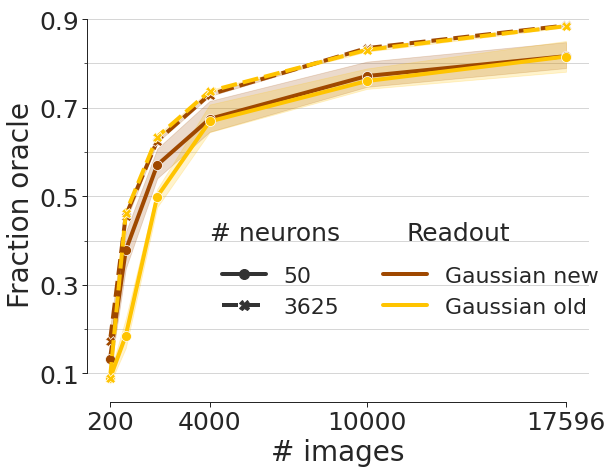

In [48]:
scoring_measure = "fraction_oracle"
palette = [col for i, col in enumerate(sns.color_palette('bright')) if i in (5,8) ]

title = 'Direct training - readout comparison'
    
paper_rc = {'lines.linewidth': 4, 'lines.markersize': 10}  
with sns.plotting_context('paper', rc=paper_rc, font_scale=2.15), sns.color_palette('bright'), sns.axes_style('ticks'):     
    
    g = sns.relplot(x="# images", 
                    y=scoring_measure,
                    hue="Readout", 
                    style="# neurons",
                    kind="line",
                    data=data,
                    markers=True,
                    height=7,
                    aspect=0.9,
                    palette=palette) 
    
    ax = g.axes[0, 0]
    
    ax.set_xticks(np.unique(data['# images'])[[0, 3, 4, 5]])
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_xlabel("# images", fontsize=28)
    ax.set_ylabel(scoring_measure.replace('_', ' ').capitalize(), fontsize=28)
    ax.tick_params(labelsize=25)
    ax.set_yticks([.1, .3, .5, .7, .9])
    ax.set_yticks([.1, .2, .3, .4, .5, .6, .7, .8, .9], minor=True)
    ax.yaxis.grid(which='major')
    ax.yaxis.grid(which='minor')
    sns.despine(trim=True)
    plt.tight_layout()
    
    idx = [4, 5, 1, 2]
    h, l = ax.get_legend_handles_labels()
    h = [h[i] for i in idx]
    l = [l[i].capitalize() for i in idx]
    g._legend.remove()
    g.fig.legend(h,l, ncol=2, frameon=False, bbox_to_anchor=(0.45, 0.25, 0.5, 0.2), fontsize=22)
    
    # add title to the legend
    ax.text(4000, .4, "# neurons", fontsize=25, )
    ax.text(11500, .4, "Readout", fontsize=25)
    
    #g.fig.savefig('figures/' + title.title().replace(" ", "").replace(",", "-") + '.pdf', dpi=150, bbox_inches='tight')

In [126]:
# find best hyperparameters

data = pd.DataFrame((TrainedModelBayesianTransfer() * 
                     ModelBayesian * 
                     DatasetBayesian * 
                     Trainer & 
                     'model_fn = "nnsysident.models.models.se2d_fullSXF"'  
                     ).fetch()) #'trainer_hash = "3c6008284286683e7ce19e9e1269f507"'
data = pd.concat([data, data['dataset_config'].apply(pd.Series)], axis = 1)#.drop('dataset_config', axis = 1)
data = pd.concat([data, data['model_config'].apply(pd.Series)], axis = 1)#.drop('model_config', axis = 1)
data = pd.concat([data, data['trainer_config'].apply(pd.Series)], axis = 1)#.drop('model_config', axis = 1)
data = data.loc[data['multi_match_n'] == 1000]

import hiplot as hip
from nnsysident.tables.bayesian import *

one_exp_h = data.set_index('score', drop=False).copy()
cols = ['score', 'gamma_readout', 'share_features', 'image_n', 'transfer_state_dict'] #'multi_match_n', 'neuron_n',
hip.Experiment.from_dataframe(one_exp_h[cols]).display(force_full_width=False)

<IPython.core.display.Javascript object>

In [124]:
data

,model_fn,model_hash,dataset_fn,dataset_hash,trainer_fn,trainer_hash,seed,comment,score,output,fabrikant_name,trainedmodel_ts,model_config,model_fabrikant,model_comment,model_ts,dataset_config,dataset_fabrikant,dataset_comment,dataset_ts,trainer_config,trainer_fabrikant,trainer_comment,trainer_ts,paths,batch_size,multi_match_n,multi_match_base_seed,image_n,image_base_seed,neuron_n,neuron_base_seed,gamma_input,input_kern,hidden_kern,normalize,transfer_state_dict,gamma_readout,share_features,detach_core
0,nnsysident.models.models.se2d_fullSXF,003ef1da4aa55b8d84474984e0d97684,nnsysident.datasets.mouse_loaders.static_share...,fd965994ea900b3a408fa876386058c4,nnsysident.training.trainers.standard_trainer,b5b26ea7fd9075bc859c18add25efa59,1,Bayesian optimization of Hyper params..Bayesia...,0.011338,{'validation_corr': 0.011337528},kklurz,2020-08-31 14:36:15,"{'gamma_input': 1.0, 'input_kern': 15, 'hidden...",kklurz,Bayesian optimization of Hyper params.,2020-08-31 14:34:25,{'paths': ['data/static22564-2-12-preproc0.zip...,kklurz,Bayesian optimization of Hyper params.,2020-08-14 07:35:11,{'detach_core': True},kklurz,Bayesian optimization of Hyper params.,2020-08-13 12:32:49,"[data/static22564-2-12-preproc0.zip, data/stat...",64,1000.0,1.0,1000,1,NaN,NaN,1.0,15,13,False,ed4a5d0bf35948b7ea65ee48bb5b5d93.pth.tar,30.641355,False,True
1,nnsysident.models.models.se2d_fullSXF,0063bb2cd119d21b433de15d5352d1c4,nnsysident.datasets.mouse_loaders.static_share...,9c77b33c6886a18fd5cf3c7cc15278e8,nnsysident.training.trainers.standard_trainer,b5b26ea7fd9075bc859c18add25efa59,1,Bayesian optimization of Hyper params..Bayesia...,0.003857,{'validation_corr': 0.0038566638},kklurz,2020-08-31 13:15:01,"{'gamma_input': 1.0, 'input_kern': 15, 'hidden...",kklurz,Bayesian optimization of Hyper params.,2020-08-31 13:14:04,{'paths': ['data/static22564-2-12-preproc0.zip...,kklurz,Bayesian optimization of Hyper params.,2020-08-13 12:32:52,{'detach_core': True},kklurz,Bayesian optimization of Hyper params.,2020-08-13 12:32:49,"[data/static22564-2-12-preproc0.zip, data/stat...",64,1000.0,1.0,50,1,NaN,NaN,1.0,15,13,False,ed4a5d0bf35948b7ea65ee48bb5b5d93.pth.tar,520.521965,False,True
2,nnsysident.models.models.se2d_fullSXF,00725be02612af97f956b39d206c1a87,nnsysident.datasets.mouse_loaders.static_share...,fd965994ea900b3a408fa876386058c4,nnsysident.training.trainers.standard_trainer,b5b26ea7fd9075bc859c18add25efa59,1,Bayesian optimization of Hyper params..Bayesia...,0.247805,{'validation_corr': 0.24780536},kklurz,2020-08-31 12:49:22,"{'gamma_input': 1.0, 'input_kern': 15, 'hidden...",kklurz,Bayesian optimization of Hyper params.,2020-08-31 12:48:08,{'paths': ['data/static22564-2-12-preproc0.zip...,kklurz,Bayesian optimization of Hyper params.,2020-08-14 07:35:11,{'detach_core': True},kklurz,Bayesian optimization of Hyper params.,2020-08-13 12:32:49,"[data/static22564-2-12-preproc0.zip, data/stat...",64,1000.0,1.0,1000,1,NaN,NaN,1.0,15,13,False,ed4a5d0bf35948b7ea65ee48bb5b5d93.pth.tar,1.749135,True,True
4,nnsysident.models.models.se2d_fullSXF,00a43e45ae2434fbce3b5ebcf6f76345,nnsysident.datasets.mouse_loaders.static_share...,9c77b33c6886a18fd5cf3c7cc15278e8,nnsysident.training.trainers.standard_trainer,b5b26ea7fd9075bc859c18add25efa59,1,Bayesian optimization of Hyper params..Bayesia...,0.006461,{'validation_corr': 0.006461391},kklurz,2020-08-30 15:57:59,"{'gamma_input': 1.0, 'input_kern': 15, 'hidden...",kklurz,Bayesian optimization of Hyper params.,2020-08-30 15:56:42,{'paths': ['data/static22564-2-12-preproc0.zip...,kklurz,Bayesian optimization of Hyper params.,2020-08-13 12:32:52,{'detach_core': True},kklurz,Bayesian optimization of Hyper params.,2020-08-13 12:32:49,"[data/static22564-2-12-preproc0.zip, data/stat...",64,1000.0,1.0,50,1,NaN,NaN,1.0,15,13,False,d99820ef586bbebcfce36d7bc89877f3.pth.tar,18.737260,False,True
5,nnsysident.models.models.se2d_fullSXF,012342292214d37ebf9043d5b41f9682,nnsysident.datasets.mouse_loaders.static_share...,c1442847e9574e6ca83abf549be

In [118]:
# find best hyperparameters

data = pd.DataFrame((TrainedModelBayesian() * 
                     ModelBayesian * 
                     DatasetBayesian * 
                     Trainer & 
                     'model_fn = "nnsysident.models.models.se2d_fullSXF"'  
                     ).fetch()) #'trainer_hash = "3c6008284286683e7ce19e9e1269f507"'
data = pd.concat([data, data['dataset_config'].apply(pd.Series)], axis = 1)#.drop('dataset_config', axis = 1)
data = pd.concat([data, data['model_config'].apply(pd.Series)], axis = 1)#.drop('model_config', axis = 1)
data = pd.concat([data, data['trainer_config'].apply(pd.Series)], axis = 1)#.drop('model_config', axis = 1)

import hiplot as hip
from nnsysident.tables.bayesian import *

one_exp_h = data.set_index('score', drop=False).copy()
cols = ['score', 'gamma_readout', 'share_features', 'multi_match_n', 'image_n']
hip.Experiment.from_dataframe(one_exp_h[cols]).display(force_full_width=False)

<IPython.core.display.Javascript object>

In [110]:
data

,model_fn,model_hash,dataset_fn,dataset_hash,trainer_fn,trainer_hash,seed,comment,score,output,fabrikant_name,trainedmodel_ts,model_config,model_fabrikant,model_comment,model_ts,dataset_config,dataset_fabrikant,dataset_comment,dataset_ts,trainer_config,trainer_fabrikant,trainer_comment,trainer_ts,paths,batch_size,multi_match_n,multi_match_base_seed,image_n,image_base_seed,gamma_input,input_kern,hidden_kern,normalize,gamma_readout,share_features
0,nnsysident.models.models.se2d_fullSXF,00241b1a9e0fa59d10dc171bd2f171ec,nnsysident.datasets.mouse_loaders.static_share...,1e125af2ec0a7a3d5593c2739a153d92,nnsysident.training.trainers.standard_trainer,d41d8cd98f00b204e9800998ecf8427e,1,Bayesian optimization of Hyper params..Bayesia...,0.264327,{'validation_corr': 0.26432738},kklurz,2020-08-13 17:13:55,"{'gamma_input': 1.0, 'input_kern': 15, 'hidden...",kklurz,Bayesian optimization of Hyper params.,2020-08-13 16:45:53,{'paths': ['data/static22564-2-12-preproc0.zip...,kklurz,Bayesian optimization of Hyper params.,2020-08-13 12:21:22,{},kklurz,Bayesian optimization of Hyper params.,2020-08-13 12:19:39,"[data/static22564-2-12-preproc0.zip, data/stat...",64,3625,1,4399,1,1.0,15,13,False,0.051154,False
1,nnsysident.models.models.se2d_fullSXF,0068b478f213b5cbf438ce6603e218b3,nnsysident.datasets.mouse_loaders.static_share...,46848c884c51120daed862ed36c82dab,nnsysident.training.trainers.standard_trainer,d41d8cd98f00b204e9800998ecf8427e,1,Bayesian optimization of Hyper params..Bayesia...,0.073154,{'validation_corr': 0.073154226},kklurz,2020-08-14 03:42:23,"{'gamma_input': 1.0, 'input_kern': 15, 'hidden...",kklurz,Bayesian optimization of Hyper params.,2020-08-14 03:39:28,{'paths': ['data/static22564-2-12-preproc0.zip...,kklurz,Bayesian optimization of Hyper params.,2020-08-13 18:14:59,{},kklurz,Bayesian optimization of Hyper params.,2020-08-13 12:19:39,"[data/static22564-2-12-preproc0.zip, data/stat...",64,1000,1,200,1,1.0,15,13,False,9.378291,True
2,nnsysident.models.models.se2d_fullSXF,006deca672dd2dea5a4c12383e0aaba9,nnsysident.datasets.mouse_loaders.static_share...,ef8834b4454886f5e1cd2fdd00236272,nnsysident.training.trainers.standard_trainer,d41d8cd98f00b204e9800998ecf8427e,1,Bayesian optimization of Hyper params..Bayesia...,0.055642,{'validation_corr': 0.05564211},kklurz,2020-08-13 14:13:29,"{'gamma_input': 1.0, 'input_kern': 15, 'hidden...",kklurz,Bayesian optimization of Hyper params.,2020-08-13 14:12:40,{'paths': ['data/static22564-2-12-preproc0.zip...,kklurz,Bayesian optimization of Hyper params.,2020-08-13 12:25:57,{},kklurz,Bayesian optimization of Hyper params.,2020-08-13 12:19:39,"[data/static22564-2-12-preproc0.zip, data/stat...",64,50,1,200,1,1.0,15,13,False,0.000521,False
3,nnsysident.models.models.se2d_fullSXF,0075b53459101a185c770fe8dca87101,nnsysident.datasets.mouse_loaders.static_share...,46848c884c51120daed862ed36c82dab,nnsysident.training.trainers.standard_trainer,d41d8cd98f00b204e9800998ecf8427e,1,Bayesian optimization of Hyper params..Bayesia...,0.084099,{'validation_corr': 0.0840995},kklurz,2020-08-13 21:25:08,"{'gamma_input': 1.0, 'input_kern': 15, 'hidden...",kklurz,Bayesian optimization of Hyper params.,2020-08-13 21:22:38,{'paths': ['data/static22564-2-12-preproc0.zip...,kklurz,Bayesian optimization of Hyper params.,2020-08-13 18:14:59,{},kklurz,Bayesian optimization of Hyper params.,2020-08-13 12:19:39,"[data/static22564-2-12-preproc0.zip, data/stat...",64,1000,1,200,1,1.0,15,13,False,0.012585,False
4,nnsysident.models.models.se2d_fullSXF,00a7d2ae33824066f66d45bd4d804e95,nnsysident.datasets.mouse_loaders.static_share...,1e125af2ec0a7a3d5593c2739a153d92,nnsysident.training.trainers.standard_trainer,d41d8cd98f00b204e9800998ecf8427e,1,Bayesian optimization of Hyper params..Bayesia...,0.253259,{'validation_corr': 0.25325918},kklurz,2020-08-13 13:58:34,"{'gamma_input': 1.0, 'input_kern': 15, 'hidden...",kklurz,Bayesian optimization of Hyper params.,2020-08-13 13:47:59,{'paths': ['data/static22564-2-12-preproc0.zip...,kk

In [117]:
len(data.loc[(data['image_n'] == 200) & (data['multi_match_n'] == 1000)])

200

---

In [ ]:
# change path here
paths = ['data/static22564-2-12-preproc0.zip',
                     'data/static22564-2-13-preproc0.zip',
                     'data/static22564-3-8-preproc0.zip',
                     'data/static22564-3-12-preproc0.zip']

#paths = ['data/static22564-2-12-preproc0.zip']
dataset_fn = 'nnsysident.datasets.mouse_loaders.static_shared_loaders'
dataset_config = dict(
    paths=paths,
    batch_size=64,
    seed=1,
    #image_n=50,
    #image_base_seed=1,
    #multi_match_n=972,
    #multi_match_base_seed=1,
    #exclude_multi_match_n = 3625,

)

dataloaders = builder.get_data(dataset_fn, dataset_config)

# Get Model

### The New gaussian readout: change gauss_type for the different modes

In [ ]:
model_fn = 'nnsysident.models.models.se2d_spatialxfeaturelinear'

model_config = { 'gamma_input': 1.0,
                 'input_kern': 15,
                 'hidden_kern': 13,
                 'gamma_readout': 0.011027209808690062}


model = builder.get_model(model_fn=model_fn, model_config=model_config, dataloaders=dataloaders, seed=1)
model_real = builder.get_model(model_fn=model_fn, model_config=model_config, dataloaders=dataloaders, seed=1)
model_start = builder.get_model(model_fn=model_fn, model_config=model_config, dataloaders=dataloaders, seed=1)

In [ ]:
core_dict = torch.load('f8acb861ca08a5baa6a2824ca33f51aa.pth.tar') # score: 0.354544

def get_grids(my_model):
    grids = {}
    for key, readout in my_model.readout.items():
        grid = readout.grid.squeeze().cpu().data.numpy()
        grids[key] = grid
    return grids

list_of_load = [] #'scales', '_features' ,'mu_transform.0.weight', 'mu_transform.0.bias'
list_of_detach = []



model_real.load_state_dict(core_dict, strict=False)
real_grids = get_grids(model_real)

remove=[]
keep=[]
for key in core_dict.keys():
    name = '.'.join(key.split('.')[2:])
    if key.split('.')[0] == 'readout': 
        if not np.isin(name, list_of_load):
            print('Not loading:    {}'.format(key))
            remove.append(key)
        else:
            keep.append(key)
for key in keep:
    print('Loading:  {}'.format(key))

for k in remove: del core_dict[k]
model_start.load_state_dict(core_dict, strict=False)
start_grids = get_grids(model_start)



model.load_state_dict(core_dict, strict=False)

for param in model.named_parameters():
    name = '.'.join(param[0].split('.')[2:])
    if param[0].split('.')[0] == 'readout':
        if np.isin(name, list_of_detach):
            print('detaching:    {}'.format(param[0]))
            param[1].requires_grad = False

# Get Trainer

In [ ]:
trainer_fn = 'nnsysident.training.trainers.standard_trainer'
trainer_config = dict(track_training=True) #detach_core=True, 
trainer = builder.get_trainer(trainer_fn, trainer_config)

# Run Training

In [ ]:
score, output, model_state = trainer(model=model, dataloaders=dataloaders, seed=1)

In [ ]:
import hiplot as hip
from nnsysident.tables.bayesian import *

data = pd.DataFrame((TrainedModelBayesian() * ModelBayesian() & 'model_fn = "nnsysident.models.models.se2d_fullSXF"').fetch())
data = pd.concat([data, data['model_config'].apply(pd.Series)], axis = 1)

one_exp_h = data.set_index('score', drop=False).copy()
cols = ['score', 'gamma_readout', 'share_features', 'normalize' ]
hip.Experiment.from_dataframe(one_exp_h[cols]).display(force_full_width=False)